# Result Data Exploration
Helps pick β for the leaderboard model.

Crucial for taking into account relative pace, not just win/lose.

## Filter dataset

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats

from constants import RACES_FILE_PATH

YEAR          = 2025          # set to None to include all years
DISTANCE_NAME = "lūsis" # set to None to include all distances (options 'vāvere', 'zaķis', 'stirnu_buks', 'lūsis')

TITLE_SUFFIX = f"({YEAR} - {DISTANCE_NAME})"

In [27]:
import json
from models.stirnu_buks import parse_stirnu_buks_to_dataframes

races = json.loads(RACES_FILE_PATH.read_text())
races_sb_raw: list[dict] = races.get("stirnu_buks")

races_df, results_df = parse_stirnu_buks_to_dataframes(races_sb_raw)

In [28]:
races_df.tail()

,year,name,location,event_no,no_events_season,distance_name,distance_km,distance_km_actual
race_id,,,,,,,,
6,2025,Jaunakmenes Stirnu buks (LT),"Jaunakmene, Lietuva",2,6,stirnu_buks,21.0,None
7,2025,Saulgriežu nakts Stirnu buks,Buses pilskalns,3,6,stirnu_buks,22.3,None
8,2025,Sēlijas Stirnu buks & Vylks,Bebrene,4,6,stirnu_buks,23.5,None
9,2025,Valmieras Pilsēttakas Stirnu buks,Valmiera,5,6,stirnu_buks,24.7,None
10,2025,Pļaviņu Lielā fināla Stirnu buks,Jankas/Jaujas,6,6,stirnu_buks,20.0,None


In [29]:
import pandas as pd

mask = pd.Series(True, index=races_df.index)
if YEAR:
    mask &= races_df["year"] == YEAR
if DISTANCE_NAME:
    mask &= races_df["distance_name"].astype(str) == DISTANCE_NAME

filtered_race_ids = races_df[mask].index
races_df   = races_df.loc[filtered_race_ids]
results_df = results_df[results_df["race_id"].isin(filtered_race_ids)]

print(f"Races: {len(races_df)}, Results: {len(results_df)}, Unique participants: {results_df['participant'].nunique()}")

Races: 5, Results: 1239, Unique participants: 572


### Calculate pace

For 2025 final (pursuit race) uses individual time.

In [30]:
from datetime import time

def to_seconds(t) -> float:
    if isinstance(t, time):
        return t.hour * 3600 + t.minute * 60 + t.second
    return float('nan')

results_df['result_s'] = results_df['result'].apply(to_seconds)
results_df['pace'] = results_df['result_s'] / results_df['race_id'].map(races_df['distance_km'])

In [31]:
def get_race_seconds(row):
    race_meta = races_df.loc[row['race_id']]
    is_final = race_meta['event_no'] == race_meta['no_events_season']
    is_2025 = race_meta['year'] == 2025
    if is_final and is_2025 and pd.notna(row.get('track_time')):
        return to_seconds(row['track_time'])
    return row['result_s']

results_df['pace_s'] = results_df.apply(get_race_seconds, axis=1)
results_df['pace'] = results_df['pace_s'] / results_df['race_id'].map(races_df['distance_km'])

## Do race results follow a normal distribution?

Currently I've looked at 2025 'Stirnu Buks' and 'Lūsis' distances, and the answer is no.

Both sides of the field are slower than expected.

### Shapiro-Wilk test

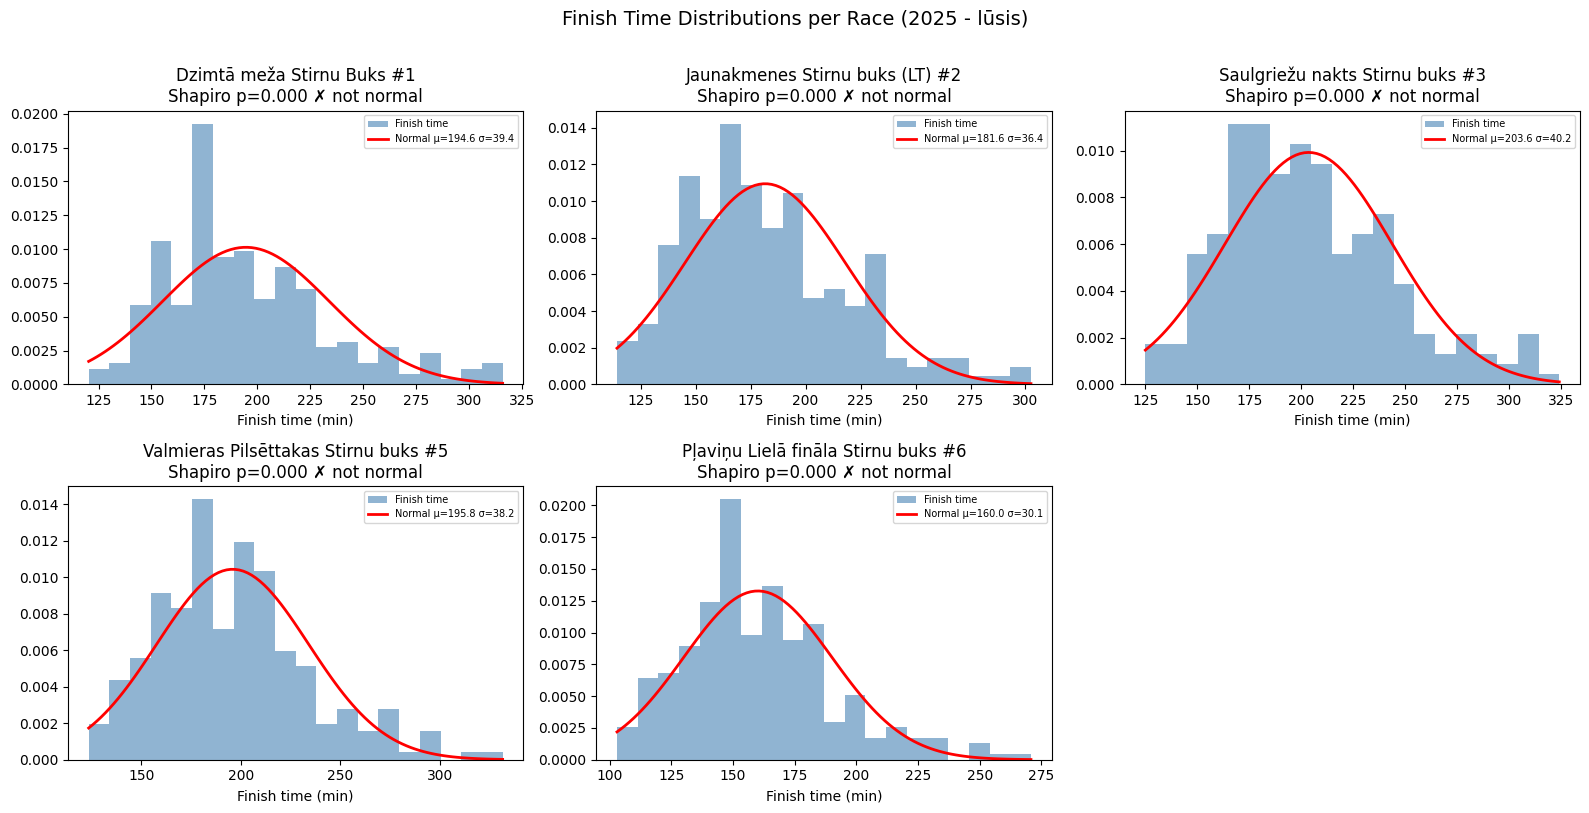

In [32]:
race_ids = races_df.index.tolist()
n_cols = 3
n_rows = int(np.ceil(len(race_ids) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for ax, race_id in zip(axes, race_ids):
    subset = results_df[results_df['race_id'] == race_id]['pace_s'].dropna()
    race_name = f"{races_df.loc[race_id, 'name']} #{races_df.loc[race_id, 'event_no']}"

    ax.hist(subset / 60, bins=20, density=True, alpha=0.6, color='steelblue', label='Finish time')

    # Fit normal
    mu, std = stats.norm.fit(subset / 60)
    x = np.linspace((subset / 60).min(), (subset / 60).max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label=f'Normal μ={mu:.1f} σ={std:.1f}')

    # Shapiro-Wilk test
    if len(subset) >= 8:
        _, p = stats.shapiro(subset)
        ax.set_title(f"{race_name}\nShapiro p={p:.3f} {'✓ normal' if p > 0.05 else '✗ not normal'}")
    else:
        ax.set_title(race_name)

    ax.set_xlabel('Finish time (min)')
    ax.legend(fontsize=7)

for ax in axes[len(race_ids):]:
    ax.set_visible(False)

plt.suptitle(f'Finish Time Distributions per Race {TITLE_SUFFIX}', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### Q-Q Plot

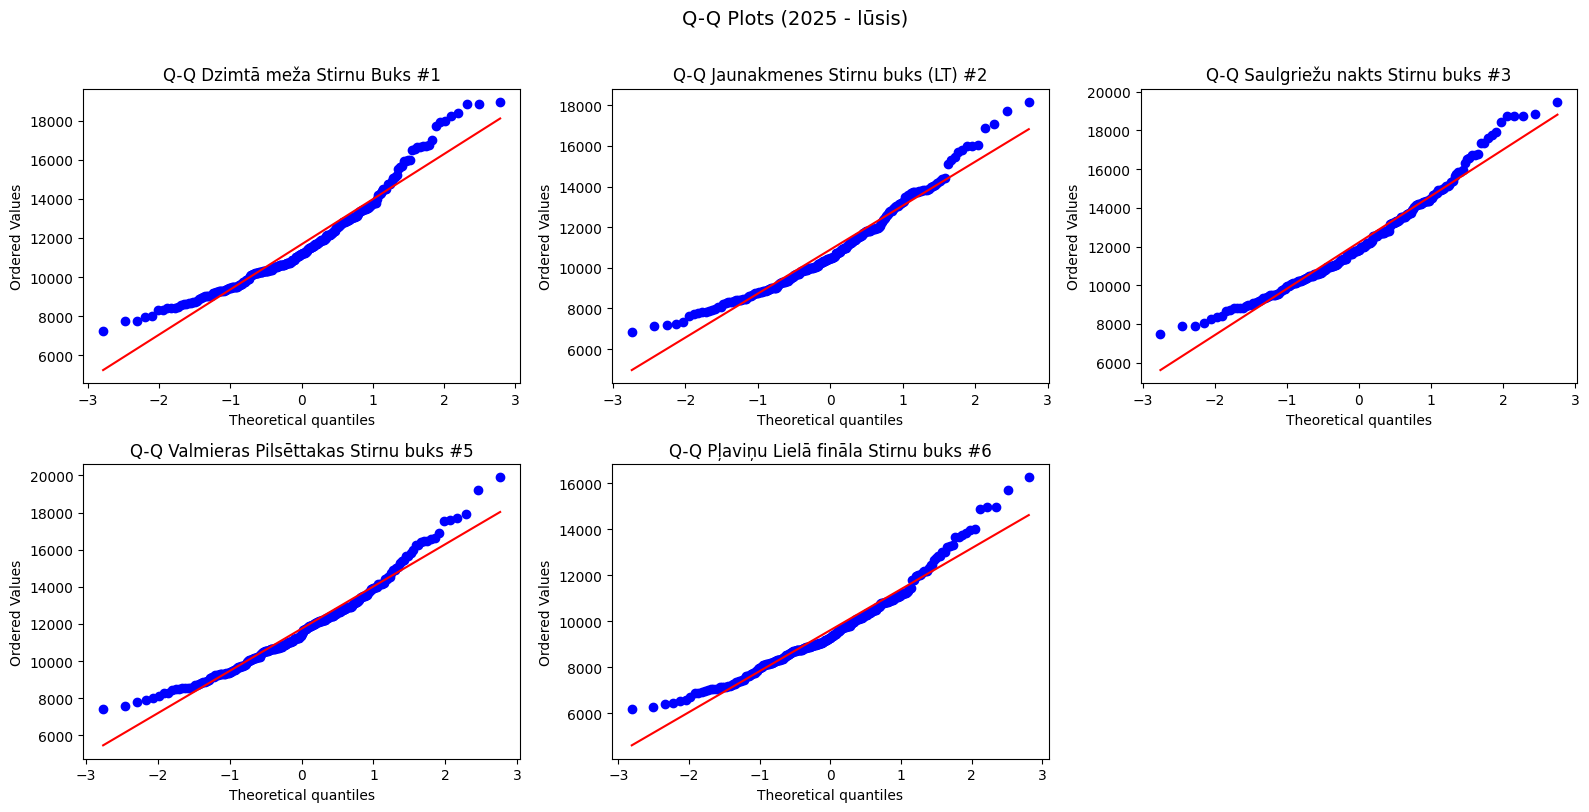

In [33]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for ax, race_id in zip(axes, race_ids):
    subset = results_df[results_df['race_id'] == race_id]['pace_s'].dropna()
    race_name = f"{races_df.loc[race_id, 'name']} #{races_df.loc[race_id, 'event_no']}"
    stats.probplot(subset, dist='norm', plot=ax)
    ax.set_title(f'Q-Q {race_name}')

for ax in axes[len(race_ids):]:
    ax.set_visible(False)

plt.suptitle(f'Q-Q Plots {TITLE_SUFFIX}', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## Mean and median paces

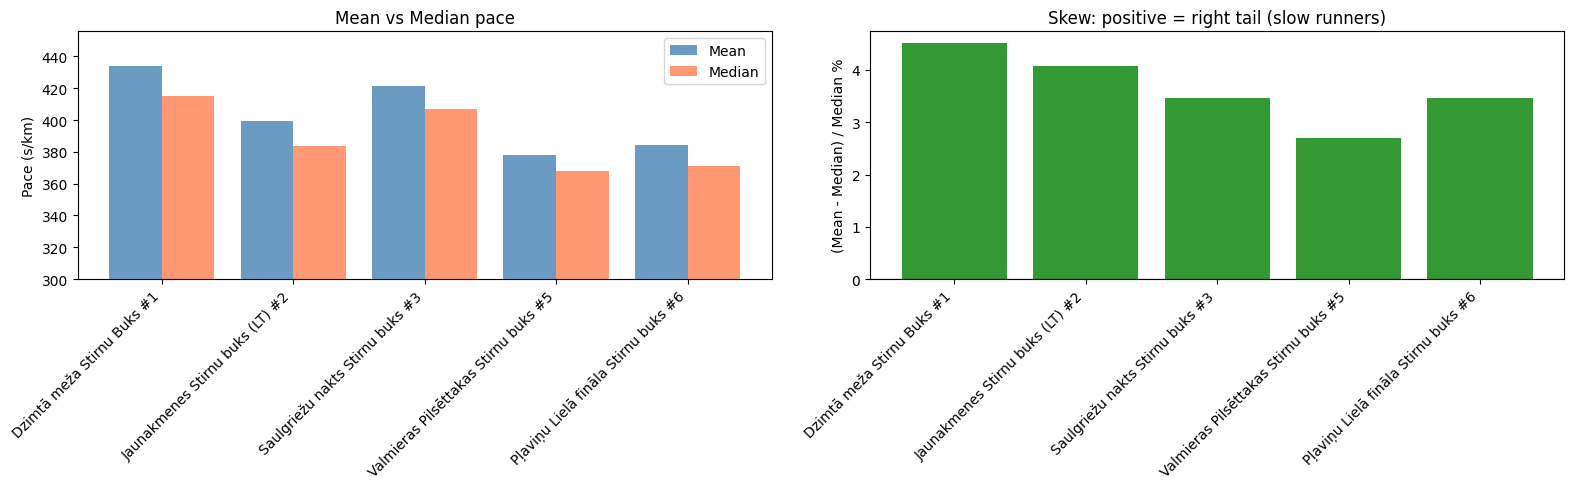

                                        label        mean      median  diff_pct
race_id                                                                        
0                  Dzimtā meža Stirnu Buks #1  434.096940  415.353160  4.512733
1             Jaunakmenes Stirnu buks (LT) #2  399.123332  383.461538  4.084319
2             Saulgriežu nakts Stirnu buks #3  421.241379  407.120690  3.468428
3        Valmieras Pilsēttakas Stirnu buks #5  377.784539  367.877814  2.692939
4         Pļaviņu Lielā fināla Stirnu buks #6  384.071541  371.200000  3.467549


In [34]:
import numpy as np
import matplotlib.pyplot as plt


agg = results_df.groupby('race_id')['pace'].agg(['mean', 'median', 'std'])
agg['diff_pct'] = (agg['mean'] - agg['median']) / agg['median'] * 100
agg['label'] = agg.index.map(lambda i: f"{races_df.loc[i, 'name']} #{races_df.loc[i, 'event_no']}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

x = np.arange(len(agg))
ax1.bar(x - 0.2, agg['mean'], 0.4, label='Mean', color='steelblue', alpha=0.8)
ax1.bar(x + 0.2, agg['median'], 0.4, label='Median', color='coral', alpha=0.8)
ax1.set_xticks(x)
ax1.set_ylim(bottom=300)
ax1.set_xticklabels(agg['label'], rotation=45, ha='right')
ax1.set_ylabel('Pace (s/km)')
ax1.set_title('Mean vs Median pace')
ax1.legend()

ax2.bar(x, agg['diff_pct'], color=['green' if v >= 0 else 'red' for v in agg['diff_pct']], alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(agg['label'], rotation=45, ha='right')
ax2.set_ylabel('(Mean - Median) / Median %')
ax2.set_title('Skew: positive = right tail (slow runners)')

plt.tight_layout()
plt.show()

print(agg[['label', 'mean', 'median', 'diff_pct']].to_string())

## Calculate normalized pace
Defined as (pace - median_pace) / median_pace

In [ ]:
# Normalized pace: (pace - median_pace) / median_pace per race
median_pace = results_df.groupby('race_id')['pace'].transform('median')
results_df['norm_pace'] = (results_df['pace'] - median_pace) / median_pace

Races: 5, Results: 1239, Unique participants: 572


In [37]:
from scipy.stats import skew, skewtest, kurtosis

for race_id in race_ids:
    subset = results_df[results_df['race_id'] == race_id]['norm_pace'].dropna()
    sk = skew(subset)
    kurt = kurtosis(subset)  # excess kurtosis, 0 = normal
    _, p = skewtest(subset)  # tests if skew is significantly different from 0
    race_name = f"{races_df.loc[race_id, 'name']} #{races_df.loc[race_id, 'event_no']}"
    print(f"{race_name}: skew={sk:.3f}, kurtosis={kurt:.3f}, skewtest p={p:.3f}")

Dzimtā meža Stirnu Buks #1: skew=0.922, kurtosis=0.620, skewtest p=0.000
Jaunakmenes Stirnu buks (LT) #2: skew=0.744, kurtosis=0.316, skewtest p=0.000
Saulgriežu nakts Stirnu buks #3: skew=0.666, kurtosis=0.184, skewtest p=0.000
Valmieras Pilsēttakas Stirnu buks #5: skew=0.736, kurtosis=0.533, skewtest p=0.000
Pļaviņu Lielā fināla Stirnu buks #6: skew=0.822, kurtosis=0.898, skewtest p=0.000


## 4. Participant normalized pace distribution (all races combined)

/var/folders/bh/2ql0bl4n16v5k06hsq1_72p00000gn/T/ipykernel_66511/795509368.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_per_race, labels=labels)


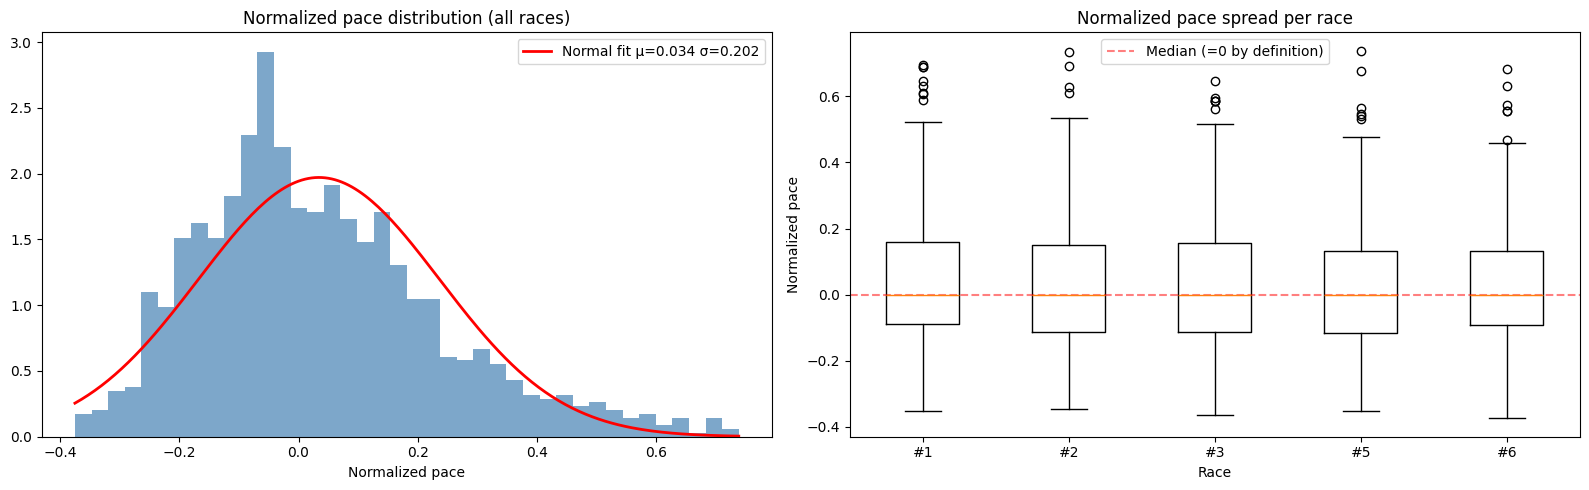


Overall norm_pace: mean=0.0343, std=0.2025
Suggested β range based on σ: 2.03 (the '10' multiplier in dynamic beta)


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
axes[0].hist(results_df['norm_pace'], bins=40, color='steelblue', alpha=0.7, density=True)
mu, std = stats.norm.fit(results_df['norm_pace'].dropna())
x = np.linspace(results_df['norm_pace'].min(), results_df['norm_pace'].max(), 200)
axes[0].plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label=f'Normal fit μ={mu:.3f} σ={std:.3f}')
axes[0].set_xlabel('Normalized pace')
axes[0].set_title('Normalized pace distribution (all races)')
axes[0].legend()

# Per race boxplot
data_per_race = [results_df[results_df['race_id'] == rid]['norm_pace'].dropna().values for rid in race_ids]
labels = [f"#{races_df.loc[rid, 'event_no']}" for rid in race_ids]
axes[1].boxplot(data_per_race, labels=labels)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5, label='Median (=0 by definition)')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Normalized pace')
axes[1].set_title('Normalized pace spread per race')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nOverall norm_pace: mean={results_df['norm_pace'].mean():.4f}, std={results_df['norm_pace'].std():.4f}")
print(f"Suggested β range based on σ: {results_df['norm_pace'].std() * 10:.2f} (the '10' multiplier in dynamic beta)")

## 5. Pairwise normalized pace gaps — informs dynamic beta multiplier

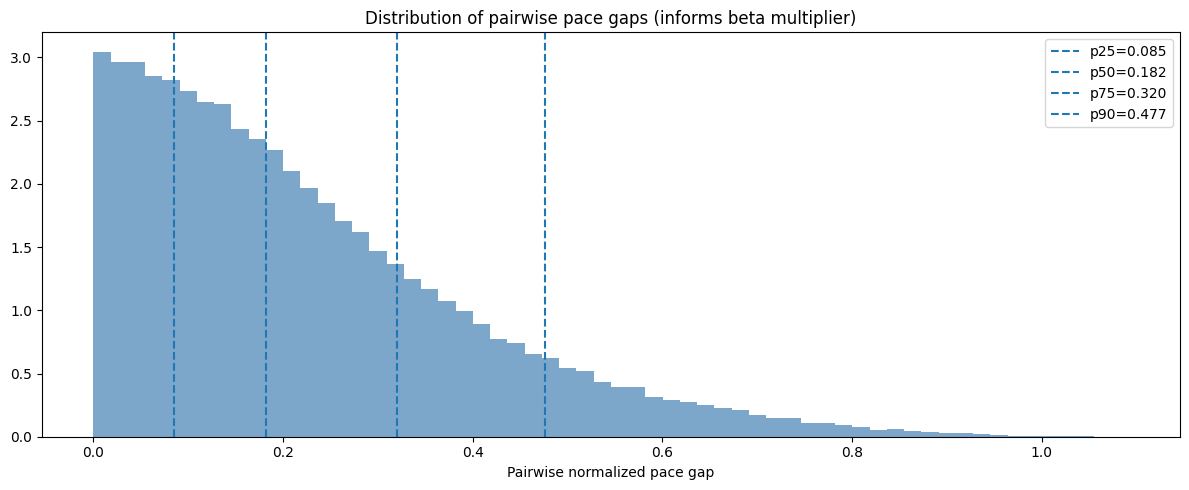

Median pairwise gap: 0.1822
p75 gap: 0.3198
p90 gap: 0.4766

If median gap is X, multiplier M should satisfy beta_base/(1 + X*M) ≈ beta_base/2
=> M ≈ 1/median_gap = 5.5


In [12]:
gaps = []
for race_id in race_ids:
    subset = results_df[results_df['race_id'] == race_id]['norm_pace'].dropna().sort_values().values
    for i in range(len(subset)):
        for j in range(i + 1, len(subset)):
            gaps.append(abs(subset[j] - subset[i]))

gaps = np.array(gaps)

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(gaps, bins=60, color='steelblue', alpha=0.7, density=True)
for p in [25, 50, 75, 90]:
    v = np.percentile(gaps, p)
    ax.axvline(v, linestyle='--', label=f'p{p}={v:.3f}')
ax.set_xlabel('Pairwise normalized pace gap')
ax.set_title('Distribution of pairwise pace gaps (informs beta multiplier)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Median pairwise gap: {np.median(gaps):.4f}")
print(f"p75 gap: {np.percentile(gaps, 75):.4f}")
print(f"p90 gap: {np.percentile(gaps, 90):.4f}")
print(f"\nIf median gap is X, multiplier M should satisfy beta_base/(1 + X*M) ≈ beta_base/2")
print(f"=> M ≈ 1/median_gap = {1/np.median(gaps):.1f}")

## 6. Repeat participant rate — how stable is the field?

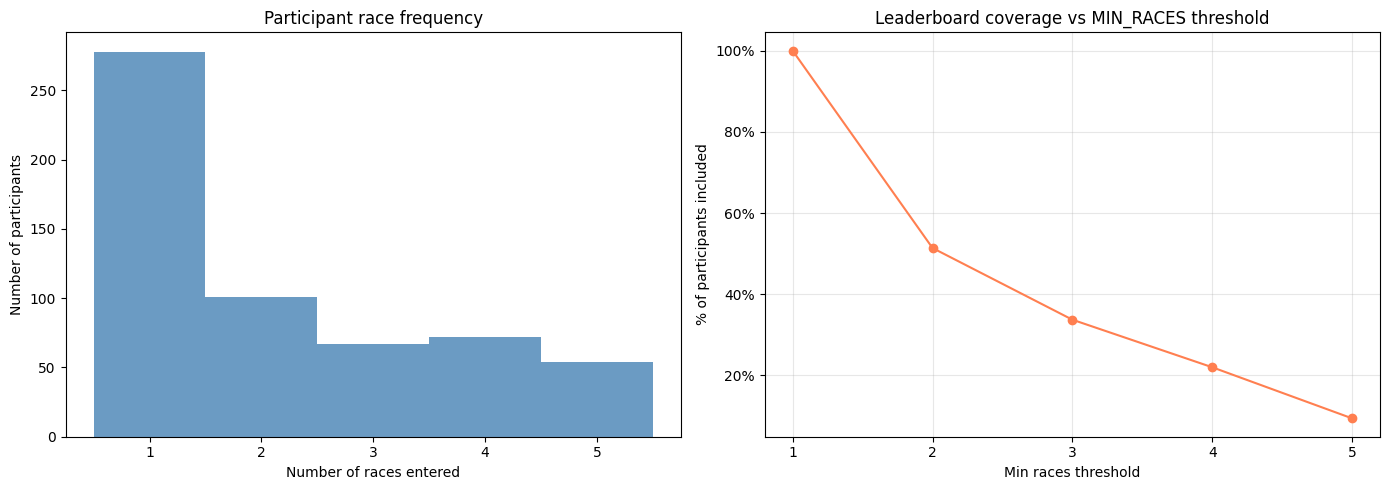

         participants
race_id              
1                 278
2                 101
3                  67
4                  72
5                  54


In [13]:
race_counts_per_participant = results_df.groupby('participant')['race_id'].count()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(race_counts_per_participant, bins=range(1, race_counts_per_participant.max() + 2),
             color='steelblue', alpha=0.8, align='left')
axes[0].set_xlabel('Number of races entered')
axes[0].set_ylabel('Number of participants')
axes[0].set_title('Participant race frequency')
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(1))

# Cumulative: what % of results come from participants with >= N races
total = len(results_df)
thresholds = range(1, race_counts_per_participant.max() + 1)
coverage = [(race_counts_per_participant >= t).sum() / race_counts_per_participant.count() * 100 for t in thresholds]
axes[1].plot(list(thresholds), coverage, marker='o', color='coral')
axes[1].set_xlabel('Min races threshold')
axes[1].set_ylabel('% of participants included')
axes[1].set_title('Leaderboard coverage vs MIN_RACES threshold')
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter())
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(race_counts_per_participant.value_counts().sort_index().rename('participants').to_frame())

## 7. Consecutive finisher pace gaps — front pack vs back

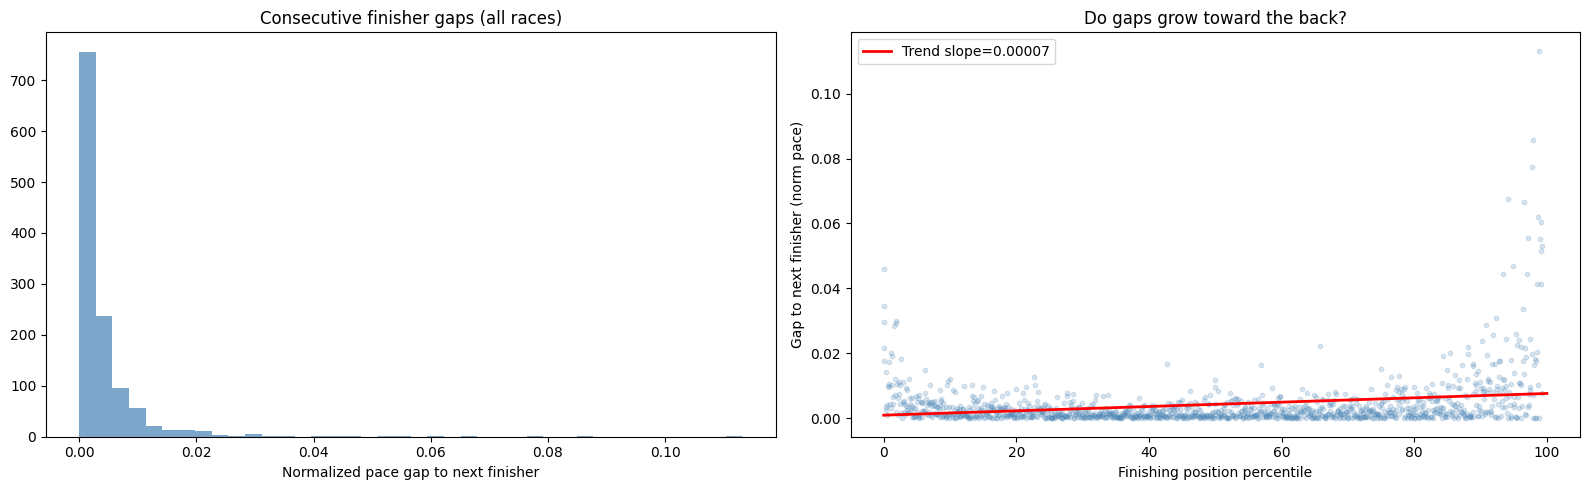

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

all_consec = []
for race_id in race_ids:
    subset = results_df[results_df['race_id'] == race_id].sort_values('pace')['norm_pace'].dropna().values
    consec = np.diff(subset)
    all_consec.extend(consec)

all_consec = np.array(all_consec)

axes[0].hist(all_consec, bins=40, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Normalized pace gap to next finisher')
axes[0].set_title('Consecutive finisher gaps (all races)')

# Does spread increase toward back? Plot gap vs finishing position percentile
pos_pcts, gap_vals = [], []
for race_id in race_ids:
    subset = results_df[results_df['race_id'] == race_id].sort_values('pace')['norm_pace'].dropna().values
    n = len(subset)
    for i, gap in enumerate(np.diff(subset)):
        pos_pcts.append(i / n * 100)
        gap_vals.append(gap)

axes[1].scatter(pos_pcts, gap_vals, alpha=0.2, s=10, color='steelblue')
# Trend line
z = np.polyfit(pos_pcts, gap_vals, 1)
p = np.poly1d(z)
xs = np.linspace(0, 100, 100)
axes[1].plot(xs, p(xs), 'r-', lw=2, label=f'Trend slope={z[0]:.5f}')
axes[1].set_xlabel('Finishing position percentile')
axes[1].set_ylabel('Gap to next finisher (norm pace)')
axes[1].set_title('Do gaps grow toward the back?')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Summary: suggested parameter values

In [15]:
norm_std = results_df['norm_pace'].std()
median_gap = np.median(gaps)
suggested_multiplier = 1 / median_gap

print("=== Suggested TrueSkill parameters ===")
print(f"μ  (mu)    = 25.0   (TrueSkill default, no strong reason to change)")
print(f"σ  (sigma) = {25/3:.2f}  (TrueSkill default = μ/3)")
print(f"β  (beta)  = 4.167  (TrueSkill default = μ/6)")
print()
print(f"=== Dynamic beta calibration ===")
print(f"norm_pace std across all races : {norm_std:.4f}")
print(f"median pairwise norm_pace gap  : {median_gap:.4f}")
print(f"suggested gap multiplier       : {suggested_multiplier:.1f}")
print(f"  → beta halves at median gap when multiplier = {suggested_multiplier:.1f}")
print(f"  → formula: beta = max(beta_min, 4.167 / (1 + gap * {suggested_multiplier:.1f}))")
print()
print(f"=== MIN_RACES threshold ===")
for t in range(1, 5):
    n = (race_counts_per_participant >= t).sum()
    pct = n / len(race_counts_per_participant) * 100
    print(f"  MIN_RACES={t}: {n} participants ({pct:.1f}% of field)")

=== Suggested TrueSkill parameters ===
μ  (mu)    = 25.0   (TrueSkill default, no strong reason to change)
σ  (sigma) = 8.33  (TrueSkill default = μ/3)
β  (beta)  = 4.167  (TrueSkill default = μ/6)

=== Dynamic beta calibration ===
norm_pace std across all races : 0.2025
median pairwise norm_pace gap  : 0.1822
suggested gap multiplier       : 5.5
  → beta halves at median gap when multiplier = 5.5
  → formula: beta = max(beta_min, 4.167 / (1 + gap * 5.5))

=== MIN_RACES threshold ===
  MIN_RACES=1: 572 participants (100.0% of field)
  MIN_RACES=2: 294 participants (51.4% of field)
  MIN_RACES=3: 193 participants (33.7% of field)
  MIN_RACES=4: 126 participants (22.0% of field)
